# Data from GDELT on Autonomus Vehicles

## Extract News Articles

**Import libraries:**

In [18]:
import gdelt
import re
import pandas as pd
import requests
from bs4 import BeautifulSoup

This project is based on the GDELT Global Knowledge Graph (GKG) Version 2.1, which expands
GDELT’s ability to quantify global human society beyond cataloging physical occurrences towards
actually representing all of the latent dimensions, geography, and network structure of the global news.
It applies an array of highly sophisticated natural language processing algorithms to each document to
compute a range of codified metadata encoding key latent and contextual dimensions of the document.
To sum up the GKG in a single sentence, it connects every person, organization, location, count, theme,
news source, and event across the planet into a single massive network that captures what’s happening
around the world, what its context is and who’s involved, and how the world is feeling about it, every
single day.

**Read in input data from file queried through GDELT web interface:**  
We used the GDELT GKG web-interface @ http://analysis.gdeltproject.org/module-gkg-exporter.html to query the GDELT GKG database with the following inputs in the query and got 4089 entries:

Start Date = 03/01/2018  
End Date = 03/31/2018  
Must have ALL these keywords: car  
Must also have AT LEAST ONE of: self_driving, self-driving, autonomous, automated, autonomous_driving, automated_driving, autonomous_vehicle, autonomous_vehicles, automated_vehicle, automated_vehicles

In [19]:
df = pd.read_csv("20191209233601.19044.gkg.txt", sep='\t')

In [20]:
df.head()

,Unnamed: 0,Unnamed: 0.1,Date,NumArticles,Counts,Themes,Locations,Persons,Organizations,ToneData,CAMEOEvents,Sources,SourceURLs
0,0,0,20180301,1,NaN,WB_1921_PRIVATE_SECTOR_DEVELOPMENT;WB_405_BUSI...,"1#China#CH#CH#35#105#CH;4#Shanghai, Shanghai, ...",robin li;lihong qin,motor corp ltd;information technology;xinhua;s...,"0.873362445414847,2.18340611353712,1.310043668...",735029480,newsweek.com,http://www.newsweek.com/self-driving-cars-fina...
1,1,1,20180301,1,NaN,TAX_FNCACT;TAX_FNCACT_STUDENT;TAX_FNCACT_STUDE...,1#United Kingdom#UK#UK#54#-4#UK,andrew deakin,cardiff university,"4.02476780185759,4.64396284829721,0.6191950464...",NaN,theengineer.co.uk,https://www.theengineer.co.uk/formula-student-...
2,2,2,20180301,1,NaN,TAX_FNCACT;TAX_FNCACT_PILOT;EPU_ECONOMY_HISTOR...,"3#Miami, Florida, United States#US#USFL#25.774...",john kwant;sam abuelsamid;sherif marakby;carlo...,google;nissan motor co;ford motor co;consumer ...,"0.812182741116751,2.23350253807107,1.421319796...",NaN,therepublic.com,http://www.therepublic.com/2018/02/28/us-ford-...
3,3,3,20180301,2,NaN,TAX_FNCACT;TAX_FNCACT_REGULATORS;PUBLIC_TRANSP...,"3#Washington, Washington, United States#US#USD...",donald trump;derek kan;barack obama;elaine chao,railroad administration;transit administration...,"0,1.34228187919463,1.34228187919463,2.68456375...","734,827,665,734,827,000,000,000,000,000,000,00...",reuters.com;reuters.com,https://www.reuters.com/article/us-autos-selfd...
4,4,4,20180301,2,NaN,TAX_WORLDLANGUAGES;TAX_WORLDLANGUAGES_DEUTSCH;...,"4#Shanghai, Shanghai, China#CH#CH23#31.2222#12...",li chungen;huang changjiang;deutsch fran,google;china tibet online china radio internat...,"1.34328358208955,2.08955223880597,0.7462686567...",NaN,bjreview.com.cn;bjreview.com,http://www.bjreview.com.cn/./Latest_Headlines/...


**Note, this data already have sentiment analysis from Google. See first number in column `ToneData`:**   
This is the average “tone” of the document as a whole.
The score ranges from -100 (extremely negative) to +100 (extremely positive). Common
values range between -10 and +10, with 0 indicating neutral. This is calculated as
Positive Score minus Negative Score. **

In [21]:
float(df.ToneData[0].split(",")[0])

0.873362445414847

**Define scrapper that retrieves paragraphs from news articles that are larger than 50 characters. Total size of the record is kept below 9999 characters.**

In [ ]:
tot_count = 0
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
def gettext(url):
    minparagraph=50
    maxtotal=9999
    global tot_count
    tot_count += 1
    if(tot_count%10 == 0): print(tot_count, end =" ")
    try:
        result = requests.get(url, headers=headers)
        c = result.content
        soup = BeautifulSoup(c)
        tempnews=[]
        count=0
        for tag in soup.findAll('p'):
            temptext=tag.getText()
            count+=len(temptext)
            if len(temptext)>minparagraph and count<maxtotal:
                tempnews.append(temptext)
        news=" ".join(x for x in tempnews)
    except:
        news = ""
    
    # clean record
    news.replace("\n", " ")
    news.replace("\t", " ")
    news.replace("\r", " ")
    news.replace("_", " ")
    news = re.sub(r'\s+', ' ', news).strip()
    return news

**The scrapper accepts an URL for news article in the following form:**

In [ ]:
df["SourceURLs"][0]

**The scrapper returns text of a news article as string (cleaned from newlines and multiple spaces, some html tags still might sneak in):**

In [ ]:
gettext(df["SourceURLs"][0])

**Create new column in the dataframe wich contains text of news articles:**

In [ ]:
df['text']= df['SourceURLs'].apply(lambda x: gettext(x))

**Save data frame to a file (tab separated):**

In [ ]:
df.to_csv("20191209233601.19044.gkg.withtext.txt", sep='\t')

In [22]:
df = pd.read_csv("20191209233601.19044.gkg.withtext.txt", sep='\t', index_col=0)

## Read Data and Check for Consistency

**Print out examples of retrieved news articles. Record `0` looks good:**

In [23]:
df['text'][0]

'China issued licenses to auto makers on Thursday that allow self-driving vehicles to be road tested for the first time, the state-owned Xinhua news agency reported. Two licenses were offered to Shanghai-based SAIC Motor Corp Ltd, and the other went to electric vehicle start-up NIO, Xinhua reported. NIO confirmed it received a license. There was no immediate comment from SAIC. The licenses would allow operators to test drive the vehicles on a 5.6-km (3.5-mile) public road in Jiading District of Shanghai, Xinhua said. The licenses were issued after Robin Li, the boss of China\'s biggest search engine Baidu, tested his firm\'s driverless car on Beijing\'s roads in July, stirring controversy as there were no rules for such a test, the agency said. NIO said it had received its license from Shanghai Municipal Government. "We will now be able to further the development of our autonomous driving technologies," NIO Co-Founder and President Lihong Qin said in the statement. Read more: Driverles

**Print out examples of retrieved news articles. Record `4` is empty, so later we will check how many such records we got and filter them out in analysis:**

In [24]:
df['text'][4]

nan

**Print out examples of retrieved news articles. Record `7` has at the end some html tags got in. It might be good to clean them later.**

In [25]:
df['text'][7][-1000:]

'brake automatically.”That’s why I’m really high on this technology,” he said. var mediaContent = "media\\\\:content,content"; (function() { var now = new Date(); var cookieName = new RegExp(\'MSPAN_Paywall_views_\' + now.getMonth()); window.MSPAN = { Paywall: { totalViews: function() { var cookies = document.cookie.split(\'; \'); var val = 0; if (!cookieName.test(document.cookie)) { return 0; } for (var i = 0; i < cookies.length; i++) { if (cookieName.test(cookies[i])) { val = parseInt(cookies[i].split(\'=\')[1]); } } return val; } } }; }()); (function(){ "use strict"; if(/logout/.test(window.location.search)){ var date = new Date(); var cookieString = "MSPAN_Paywall_user=0; domain=."+document.location.host.replace(/^\\w+\\./, \'\')+"; path=/; expires=" + date.toGMTString(); var cookieString2 = "MSPAN_Paywall_user=0; domain="+document.location.host+"; path=/; expires=" + date.toGMTString(); date.setHours(date.getHours() - 1); document.cookie = cookieString; document.cookie = cookieStr

**Print out examples of retrieved news articles. Records `25`, `119`, `160` show a error messages. It might be good to clean them later.**

In [26]:
df['text'][25]

'The host name resolution (DNS lookup) for this host name ( google1299.com ) has failed. The Internet address may be misspelled or obsolete, the host ( google1299.com ) may be temporarily unavailable, or the DNS server may be unresponsive. Please check the spelling of the Internet address entered. If it is correct, try this request later. Date: Thu, 12 Dec 2019 05:44:35 GMT Username: NAM\\tz5b44@NAM Source IP: 10.45.142.170 URL: GET http://google1299.com/ Category: Uncategorized URLs Reason: UNKNOWN Proxy: DCWEPSCPR015.edc.nam.gm.com Notification: DNS_FAIL'

In [27]:
df['text'][119][:300]

"Page Not Found #goog-wm { } #goog-wm h3.closest-match { } #goog-wm h3.closest-match a { } #goog-wm h3.other-things { } #goog-wm ul li { } #goog-wm li.search-goog { display: block; } var GOOG_FIXURL_LANG = 'en'; var GOOG_FIXURL_SITE = 'https://drudge.com/'; The page /news/219569/fully-self-driving-ca"

In [28]:
df['text'][160][:300]

'The information you requested is not available at this time, please check back again soon. Mar 5, 2018 Hugh Son, Jenny Surane and Julie Verhage, Bloomberg News Banks have been warily watching Amazon.com Inc. for signs it would threaten their world. The tech giant’s latest move looks more like an opp'

**Print out examples of retrieved news articles. Records `90` is looks good but is not talking about atonomous cars. It might be good to clean them later.**

In [29]:
df['text'][90]

'The roses in this Phantom are inspired by the Phantom rose, a flower specifically bred for Rolls-Royce. Porsche is not happy with the EPA\'s result, so it hired its own team to get a better "real-world" range number. Styling is similar to the one-size-smaller XT6, but the interior draws inspiration from the Escala concept car. Ride. Handling. Space. Details of this fundamental change to the 2021 Tahoe and Suburban\'s suspension. BMW has been on a connectivity kick recently; this news comes just a week after they announced Apple CarPlay would be free. The GLA250 in front- and all-wheel-drive models is joined by the 302-hp Mercedes-AMG GLA35. Independent rear suspension finally comes to the popular full-size SUVs, increasing interior space dramatically. Here are the longer, lower, somehow more attractive behemoths in the flesh. Rear-wheel-drive V-8 wagon bliss. All yours for just $37,000. Volkswagen\'s next Atlas sees a significant facelift, changes to the powertrain, and interior upgra

## Clean the Data

**Based on the analysis above to clean the data we would have to:**  
 * `1` - Remove empty records
 * `2` - Remove duplicates
 * `3` - Remove error message or empty record
 * `4` - Remove articles not related to autonomous cars topic

We will treat point 1 and 2 by using Pandas based filters. For point 3 and 4 we will build a BERT classifier that will predict if a text belong to those categories. 

In [30]:
df2 = pd.read_csv("20191209233601.19044.gkg.withtext.txt", sep='\t', index_col=0)

In [31]:
df2.shape

(4089, 13)

**Dropping empty text** 

In [32]:
df2=df2.dropna(subset=['text'])

In [33]:
df2.shape

(3651, 13)

**Dropping duplicates** 

In [34]:
df2=df2.drop_duplicates(subset=['text'], keep='first', inplace=False)

In [35]:
df2.shape

(2998, 13)

**Save data frame to a file (tab separated):**

In [36]:
df2.to_csv("almostclean.txt", sep='\t')

**Building a BERT classifier to keep text related to autonomous cars and eliminate error messages and non related texts**  
In order to acheive that we will:
 * `1` - Manually label a part of our database
 * `3` - error message or empty record
 * `4` - duplicates
 * `2` - Build a BERT classifier using the Ktrain KERAS based wrapper
 * `3` - Train the BERT classifier
 * `4` - Use the classifier to predict text we should keep and text we should eliminate  
 NB: The below code has been inspired by a google colab @ https://colab.research.google.com/drive/1ixOZTKLz4aAa-MtC6dy_sAvc9HujQmHN#scrollTo=ytg-0FTHG7ik

In [37]:
# Import libraries
import time
import ktrain
from ktrain import text
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


using Keras version: 2.2.4


**Loading the labelled database labels are as follows:**  
 * `0` - default value
 * `1` - related to autonomous cars topic
 * `2` - not related to autonomous cars topic
 * `3` - error message or empty record
 * `4` - duplicates

In [39]:
dfbert = pd.read_csv("20191209233601.19044.gkg.Labeled.txt", sep='\t', index_col=0)
dfbert = dfbert[["text","label"]]

In [40]:
dfbert.shape

(4089, 2)

**Formating the labelled data**

In [41]:
dfbert=dfbert[dfbert['label'] != 0]
dfbert.shape

(1838, 2)

In [42]:
dfbert=dfbert[dfbert['text'] != 0]
dfbert.shape

(1838, 2)

In [43]:
dfbert=dfbert[dfbert['label'] != 4]
dfbert.shape

(1076, 2)

In [44]:
dfbert = dfbert.drop_duplicates(subset=['text'], keep='first', inplace=False)
dfbert.shape

(466, 2)

In [45]:
dfbert=dfbert.dropna(subset=['text'])
dfbert.shape

(465, 2)

In [46]:
dfbert["label"]=dfbert["label"].replace(3,0)

In [47]:
dfbert["label"]=dfbert["label"].astype(int)

**Splitting the labelled data into a train and a text dataset**

In [48]:
train, test = train_test_split(dfbert, test_size=0.2)
x_train = train.text.to_numpy()
y_train = train.label.to_numpy()
x_test = test.text.to_numpy()
y_test = test.label.to_numpy()

**Formating the data with ktrain to fit the expected input and output of a BERT model**

In [49]:
(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_array(x_train=x_train, y_train=y_train,
                                                                       x_test=x_test, y_test=y_test,
                                                                       class_names=["trash","autonomous","non_autonomous"],
                                                                       preprocess_mode='bert',
                                                                       maxlen=256, 
                                                                       max_features=35000)

preprocessing train...
language: en


preprocessing test...
language: en


**Building the BERT model**

In [50]:
model = text.text_classifier('bert', train_data=(x_train, y_train), preproc=preproc)
learner = ktrain.get_learner(model, train_data=(x_train, y_train), batch_size=6)

Is Multi-Label? False
maxlen is 256
done.


**Training the BERT model**

In [51]:
learner.fit_onecycle(2e-5, 4)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/4
372/372 [==============================] - 32s 86ms/step - loss: 0.7874 - acc: 0.6425
Epoch 2/4
372/372 [==============================] - 24s 65ms/step - loss: 0.4117 - acc: 0.8548
Epoch 3/4
372/372 [==============================] - 24s 65ms/step - loss: 0.2341 - acc: 0.9220
Epoch 4/4
372/372 [==============================] - 24s 66ms/step - loss: 0.1241 - acc: 0.9624


**Checking accuracy of results on the test dataset**

In [55]:
learner.validate(val_data=(x_test, y_test), class_names=["trash","autonomous","non_autonomous"])

                precision    recall  f1-score   support

         trash       0.88      0.64      0.74        11
    autonomous       0.90      0.98      0.94        55
non_autonomous       0.80      0.74      0.77        27

     micro avg       0.87      0.87      0.87        93
     macro avg       0.86      0.79      0.82        93
  weighted avg       0.87      0.87      0.87        93



array([[ 7,  0,  4],
       [ 0, 54,  1],
       [ 1,  6, 20]], dtype=int64)

In [56]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [57]:
predictor.get_classes()

['trash', 'autonomous', 'non_autonomous']

**Let's save the predictor for later use**

In [58]:
predictor.save('/tmp/my_predictor')

**Reload the predictor**

In [59]:
reloaded_predictor = ktrain.load_predictor('/tmp/my_predictor')

**Checking if the predictor works by asking for 10 trash examples from the non labelled dataset:**

In [60]:
my_dataframe=pd.read_csv("almostclean.txt", sep='\t', index_col=0)

In [61]:
%%capture
i=0
j=0
trash=[]
starttime=time.time()
while i <10:
    if reloaded_predictor.predict(my_dataframe["text"].tolist()[j])=="trash":
        trash.append(my_dataframe["text"].tolist()[j][:300])
        j=j+1
        i=i+1
    else:
        j=j+1
endtime=time.time()

In [62]:
print("Bert filter went throught: {} text and detected {} trash in {} seconds ".format(j,i,endtime-starttime))

Bert filter went throught: 76 text and detected 10 trash in 4.421540260314941 seconds 


In [63]:
for i in trash:
    print(i)

The page you are looking for doesn't exist.Click here to reach the Euronews homepage
We can't find the page you are looking for, we're terribly sorry, but these things happen. To find something youâ€™ll like, click a category above or use the search box.
The host name resolution (DNS lookup) for this host name ( google1299.com ) has failed. The Internet address may be misspelled or obsolete, the host ( google1299.com ) may be temporarily unavailable, or the DNS server may be unresponsive. Please check the spelling of the Internet address entered. If
It looks like nothing was found at this location. Maybe try a search?
To continue, please click the box below to let us know you're not a robot. Please make sure your browser supports JavaScript and cookies and that you are not blocking them from loading. For more information you can review our Terms of Service and Cookie Policy. For inquiries related to this message 
The host name resolution (DNS lookup) for this host name ( google1299.com

**Checking if the predictor works by asking for 10 non-autonomous examples from the non labelled dataset:**

In [64]:
%%capture
i=0
j=0
non_autonomous=[]
starttime=time.time()
while i <10:
    if reloaded_predictor.predict(my_dataframe["text"].tolist()[j])=="non_autonomous":
        non_autonomous.append(my_dataframe["text"].tolist()[j][:300])
        j=j+1
        i=i+1
    else:
        j=j+1
endtime=time.time()

In [65]:
for i in non_autonomous:
    print(i)

Nobody covers Columbus, Indiana and the surrounding areas like The Republic. 2980 N. National Road, Suite A, Columbus, IN 47201 Main Switchboard: (812) 372-7811 Toll Free: (800) 876-7811
Fr Arturo Sosa-the Superior General of Jesuits in Rome visiting Mangaluru (‘Rome of the East’) on 1 March, where he will address the staff, the Alumni and collaborators of St Aloysius Institutions-Mangaluru on Thursday, at 3 pm Mangaluru: Fr Arturo Marcelino Sosa Abascal SJ, the thirty-first and pre
Message of ‘Reconciliation & Justice’ was delivered during a speech by Jesuits Superior General Fr Arturo Sosa to Aloysians during a programme arranged on his visit to St Aloysius Institutions-Mangaluru at Loyola Hall, SAC-Mangaluru on Thursday, 1 March 2018. Mangaluru: He Came, He Saw, He Conquered
A few passing clouds, otherwise generally clear. Low 46F. Winds NW at 5 to 10 mph.. A few passing clouds, otherwise generally clear. Low 46F. Winds NW at 5 to 10 mph. The page may have moved, you may have mistyp

**Using the predictor to filter trash and non autonoums text from the dataset**

In [66]:
%%capture
my_dataframe['class']= my_dataframe['text'].apply(lambda x: reloaded_predictor.predict(x))

**Saving the datasets**

In [67]:
my_dataframe.to_csv("classifieddata.txt", sep='\t')
my_dataframe.shape

(2998, 14)

In [68]:
cleandata=my_dataframe[my_dataframe["class"]=="autonomous"]
cleandata.to_csv("cleandata.txt", sep='\t')
cleandata.shape

(2142, 14)

## Annotation and Sentiment Analysis with TextBlob

In [69]:
import nltk
from textblob import TextBlob

In [70]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

In [71]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Mario\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Mario\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [72]:
df = pd.read_csv("cleandata.txt", sep='\t', index_col=0)
df.Date = pd.to_datetime(df.Date, format="%Y%m%d")

**Define functions to calculate polarity and subjectivity for input text:**

In [73]:
def TB_Polarity (text):
    text_ = str(text)[:500]
    try:
        tb_polarity = TextBlob(text_).sentiment.polarity
    except:
        tb_polarity = -200.0
    return tb_polarity

In [74]:
def TB_Subjectivity (text):
    text_ = str(text)[:500]
    try:
        tb_subjectivity = TextBlob(text_).sentiment.subjectivity
        tb_subjectivity
    except:
        tb_subjectivity = -200.0
    return tb_subjectivity

**Calculate polarity and subjectivity for all records:**

In [75]:
%time df['tb_polarity'] = df['text'].apply(TB_Polarity)

Wall time: 1.77 s


In [76]:
df_tb_polarity01  = df[ (df.tb_polarity > -100)]

In [77]:
bydatedf_tb_polarity01 = df_tb_polarity01.groupby(['Date']).mean()

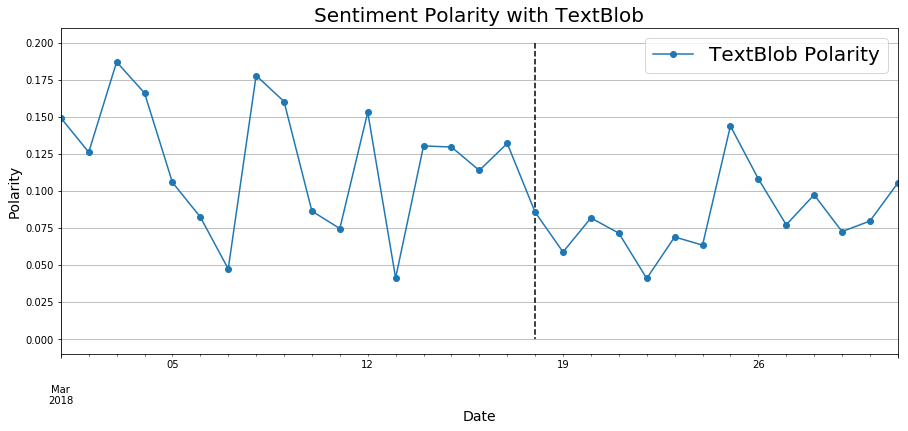

In [78]:
axe = bydatedf_tb_polarity01[['tb_polarity']].resample("1d").mean().plot(figsize=(15,6), marker='o')
axe.vlines(pd.Timestamp('2018-03-18'), 0.2, -0.0, linestyles='dashed', color='black')
axe.set_ylabel('Polarity', fontsize=14)
axe.set_xlabel('Date', fontsize=14)
axe.set_title('Sentiment Polarity with TextBlob', fontsize=20)
axe.legend(["TextBlob Polarity"], fontsize=20)
axe.grid()
plt.savefig("TB_Polarity_March2018.png")

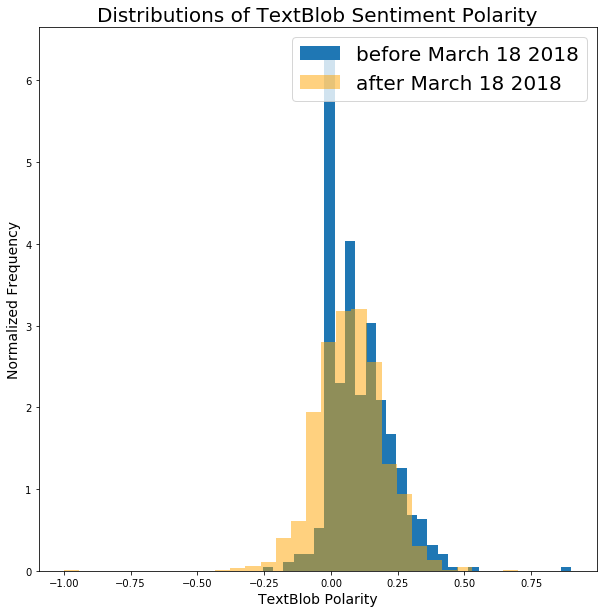

In [79]:
plt.hist(df_tb_polarity01[ df_tb_polarity01['Date'] < pd.Timestamp('2018-03-18') ]['tb_polarity'], bins=30, density=True)
plt.hist(df_tb_polarity01[ df_tb_polarity01['Date'] >= pd.Timestamp('2018-03-18') ]['tb_polarity'], bins=30, density=True, color="orange", alpha=0.5)
plt.xlabel('TextBlob Polarity', fontsize=14)
plt.ylabel('Normalized Frequency', fontsize=14)
plt.title('Distributions of TextBlob Sentiment Polarity',fontsize=20)
plt.legend(["before March 18 2018","after March 18 2018"],fontsize=20)
plt.savefig("TB_PolarityHist_March2018.png")
plt.show()

In [80]:
%time df['tb_subjectivity'] = df['text'].apply(TB_Subjectivity)

Wall time: 1.52 s


In [81]:
df_tb_subjectivity01 = df[ (df.tb_subjectivity > -100)]

In [82]:
bydatedf_tb_subjectivity=df_tb_subjectivity.groupby(['Date']).mean()

NameError: name 'df_tb_subjectivity' is not defined

In [ ]:
axe = bydatedf_tb_subjectivity[['tb_subjectivity']].resample("1d").median().plot(figsize=(15,6), marker='o')
axe.vlines(pd.Timestamp('2018-03-18'), 0.6, 0.0, linestyles='dashed', color='black')
axe.set_ylabel('Subjectivity', fontsize=14)
axe.set_xlabel('Date', fontsize=14)
axe.set_title('Sentiment Subjectivity with TextBlob', fontsize=20)
axe.legend(["TextBlob Subjectivity"], fontsize=20)
axe.grid()
plt.savefig("TB_Subjectivity_March2018.png")

In [ ]:
plt.hist(df_tb_subjectivity01[ df_tb_subjectivity01['Date'] < pd.Timestamp('2018-03-18') ]['tb_subjectivity'], bins=30, density=True)
plt.hist(df_tb_subjectivity01[ df_tb_subjectivity01['Date'] >= pd.Timestamp('2018-03-18') ]['tb_subjectivity'], bins=30, density=True, color="orange", alpha=0.5)
plt.xlabel('TextBlob subjectivity', fontsize=14)
plt.ylabel('Normalized Frequency', fontsize=14)
plt.title('Distributions of TextBlob Sentiment subjectivity',fontsize=20)
plt.legend(["before March 18 2018","after March 18 2018"],fontsize=20)
plt.savefig("TB_subjectivityHist_March2018.png")
plt.show()

**Playing with wordcloud**

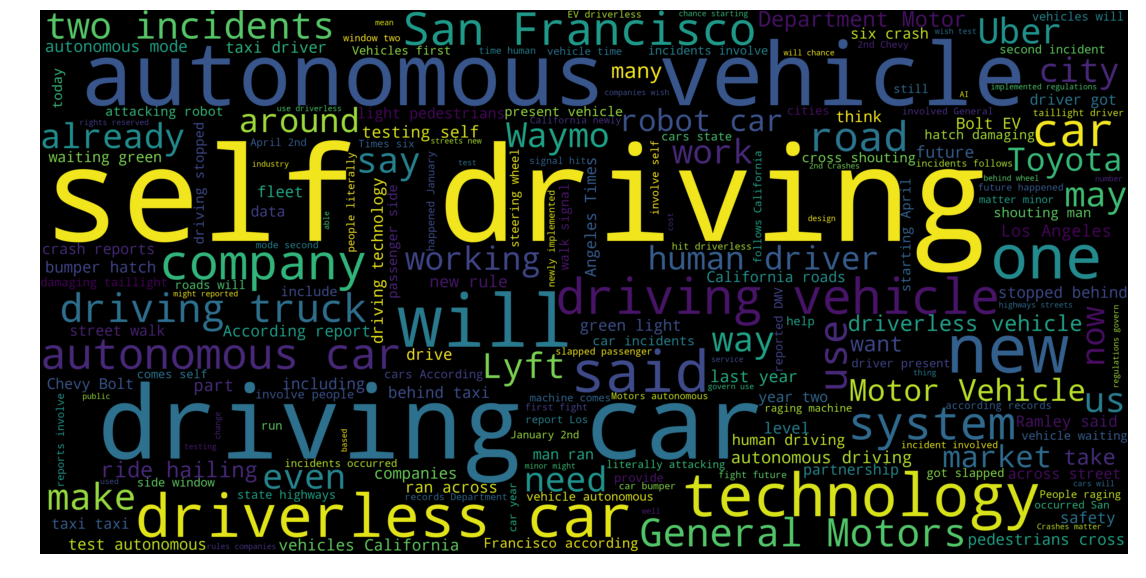

In [83]:
from wordcloud import WordCloud
mycloud = " ".join(df[df['Date'] < pd.Timestamp('2018-03-18')]['text'])
wc=WordCloud(width=4000,height=2000).generate(mycloud)
plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

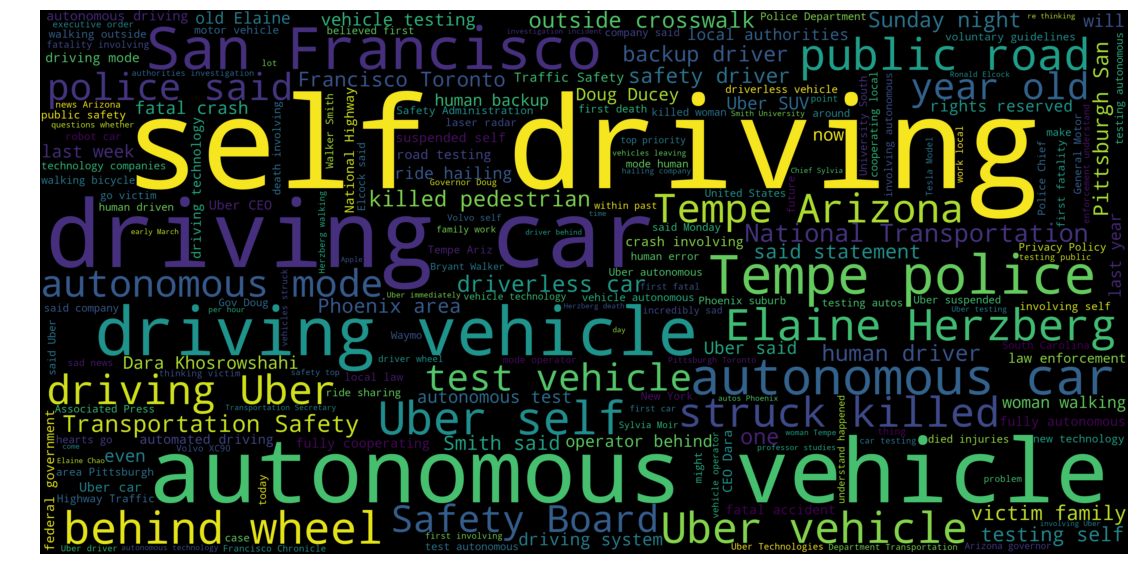

In [84]:
from wordcloud import WordCloud
mycloud = " ".join(df[df['Date'] > pd.Timestamp('2018-03-18')]['text'])
wc=WordCloud(width=4000,height=2000).generate(mycloud)
plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

Thank You